In [166]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X,y = make_blobs(n_samples=1000,n_features=2,centers=4,random_state=42,cluster_std=1.5)

In [167]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor) # as written in torch.softmax documentation

In [168]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=42)

In [169]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    accuracy = (correct/len(y_pred))*100
    return accuracy

In [170]:

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor,y: torch.Tensor):
    
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

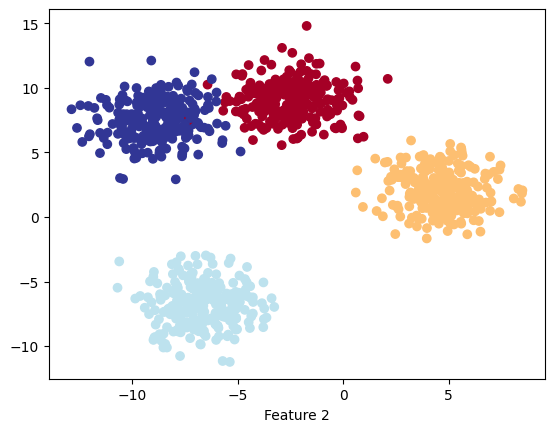

In [171]:
plt.Figure(figsize=(12,8))
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)
plt.xlabel("Feature 1")
plt.xlabel("Feature 2")
plt.show()

In [172]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [173]:
class BlobModelV0(nn.Module):
    def __init__(self,input_features=2,output_features=4,hidden_units=8):
        super().__init__()
        ''' 
            Initializes multi-class classification model
            Args:
                input_features: Number of input features to the model
                output_features: Number of output features
                hidden_units = Number of neurons in a hidden layer of a neural network
        '''

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units*2),
            nn.ELU(0.1),
            nn.Linear(in_features=hidden_units*2,out_features=hidden_units),
            nn.ELU(0.1),
            nn.Linear(in_features=hidden_units,out_features=output_features)
        )
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)
    

In [174]:
model_0 = BlobModelV0(input_features=2,output_features=4).to(device)
model_0

BlobModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ELU(alpha=0.1)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ELU(alpha=0.1)
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [175]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [176]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),lr=0.01)

In [177]:
y_logits = model_0(X_test)
y_logits.shape
print(y_logits[:2,:])
y_prob = torch.softmax(y_logits,dim=1)  # apply softmax row-wise
print(y_prob[:2,:])

tensor([[ 0.0230, -0.5230,  0.2196, -0.3224],
        [-0.0059, -1.2595,  0.8315, -0.6835]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.2853, 0.1653, 0.3473, 0.2020],
        [0.2437, 0.0696, 0.5630, 0.1238]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [178]:
res = torch.argmax(y_prob,dim=1)
res[0:5]

tensor([2, 2, 2, 0, 2], device='cuda:0')

##### Train the Model

In [179]:
torch.cuda.manual_seed(42)

epochs=100

acc = []
test_loss =[]
train_loss = []
epoch_count = [i for i in range(1,epochs+1)]

for epoch in range(epochs):
    model_0.train()

    y_train_logits = model_0(X_train)
    y_train_prob = torch.softmax(y_train_logits,dim=1)
    y_train_pred = torch.argmax(y_train_prob,dim=1)

    loss_train = loss_fn(y_train_logits,y_train)
    train_loss.append(loss_train.item())
    acc.append(accuracy_fn(y_train,y_train_pred))

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    model_0.eval()

    with torch.inference_mode():
        y_test_logits = model_0(X_test)
        y_test_prob = torch.softmax(y_test_logits,dim=1)
        y_test_pred = torch.argmax(y_test_prob,dim=1)

        loss_test = loss_fn(y_test_logits,y_test)
        test_loss.append(loss_test.item())


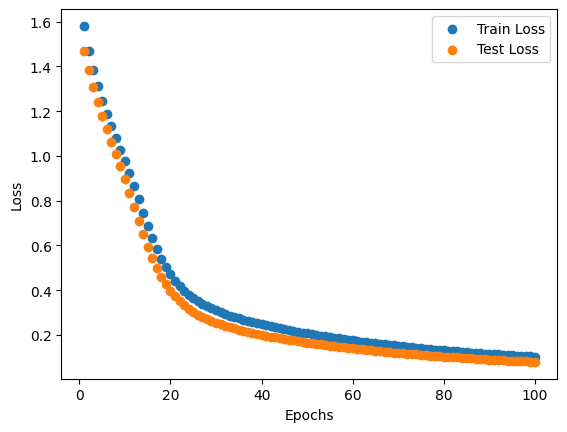

In [180]:
plt.scatter(epoch_count,train_loss,label='Train Loss')
plt.scatter(epoch_count,test_loss,label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

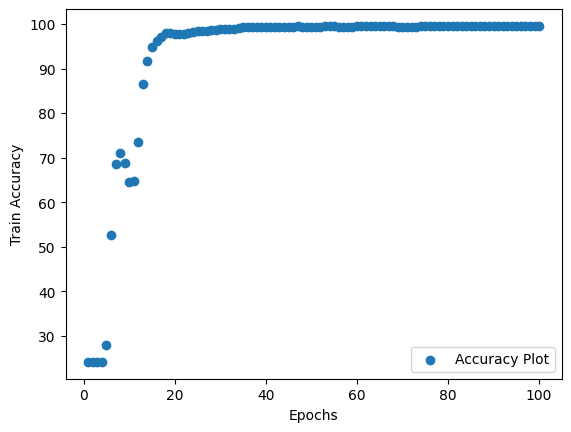

In [181]:
plt.scatter(epoch_count,acc,label="Accuracy Plot")

plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")

plt.legend()
plt.show()

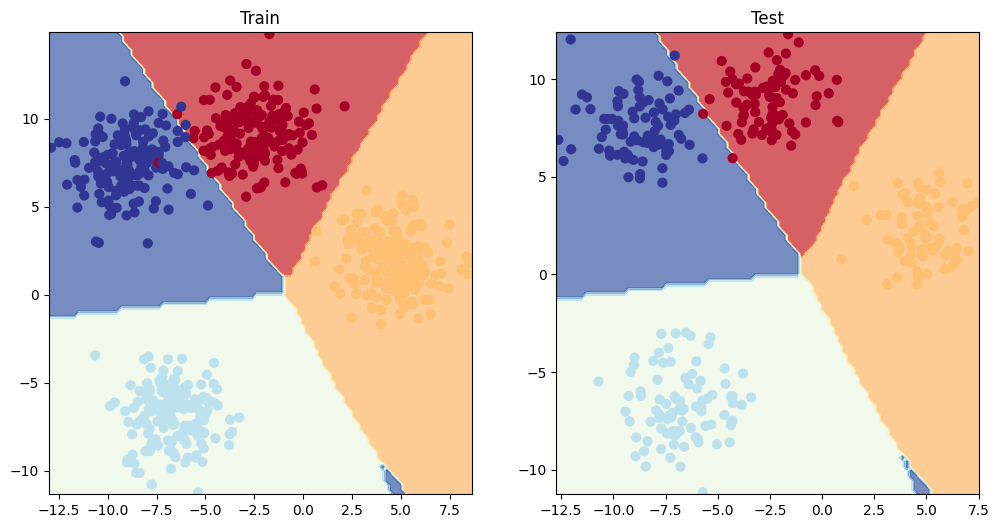

In [182]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

Observation:
- We need not to use ELU() or other non-linear activation functions as we can seperate these groups linearly.

##### Evaluating the Model

|               | Actual 1 | Actual 0 |
|--------------|----------|----------|
| **Prediction 1** | TP       | FP       |
| **Prediction 0** | FN       | TN       |


Precision: TP/(TP+FP) 
- example: spam classification, where <if a non spam mail is classified as spam> (FP) then that is a big problem, but on the other hand <if spam mail is not classified as spam> (FN) that is not a big problem compared to above. So here in this case we track precision of our model.

Recall: TP/(TP+FN)
- example: disease classification, where <if a person has a disease but classified as no disease> (FN) here this is a big issue compared to when <if person does not have disease but classified as disease> (FP), so in this case we will track the ReCall of our model.

Precision-Recall Trade-Of:
- as we increase precision, recall seems to reduce


In [183]:
!pip install torchmetrics

Refer this: 
https://medium.com/towards-data-science/beyond-accuracy-precision-and-recall-3da06bea9f6c

In [188]:
from torchmetrics import Accuracy, Precision, Recall

recall = Recall(task='MULTICLASS',num_classes=4).to(device)
precision = Precision(task="multiclass",num_classes=4).to(device)
accuracy = Accuracy(task="multiclass",num_classes=4).to(device)

model_0.to(device)
model_0.eval()
with torch.inference_mode():
    y_test_logits = model_0(X_test)
    y_test_prob = torch.softmax(y_test_logits,dim=1)
    y_test_pred = torch.argmax(y_test_prob,dim=1)
    print("Accuracy: ",accuracy(y_test_pred,y_test))
    print("Precision: ",precision(y_test_pred,y_test))
    print("Recall: ",recall(y_test_pred,y_test))


Accuracy:  tensor(0.9909, device='cuda:0')
Precision:  tensor(0.9909, device='cuda:0')
Recall:  tensor(0.9909, device='cuda:0')
